# Episode 18 — Measuring Observables in the Pauli Basis

In Qiskit, operators are the building blocks for observables, Hamiltonians, and linear maps.
In this notebook you will:

- Build sparse observables with `SparsePauliOp` and operate on them.
- Work with single-string Paulis via `Pauli`.
- Use dense `Operator` objects when full matrices are needed.
- Convert matrices to Pauli sums.
- Measure in different Pauli bases (manual basis-change vs. Estimator).

**Qiskit v2.0+** is assumed.

In [25]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator, Statevector
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import Estimator

## 1) SparsePauliOp — efficient sums of Pauli strings

`SparsePauliOp` is ideal for large operators (e.g., Hamiltonians). You specify only the non-zero Pauli terms.

Below we build a small 4‑qubit Ising-like model on a line with local X fields:

In [26]:
n = 4
couplings = [("ZZ", [i, i+1], 1.0) for i in range(n-1)]  # nearest-neighbor ZZ
x_field  = [("X",  [i],      -0.3) for i in range(n)]    # local -0.3 * X_i

H = SparsePauliOp.from_sparse_list(couplings + x_field, num_qubits=n)
print(H)

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[ 1. +0.j,  1. +0.j,  1. +0.j, -0.3+0.j, -0.3+0.j, -0.3+0.j, -0.3+0.j])


Basic algebra works as you expect: addition, scalar multiplication, composition (`@`), and tensor product.

In [27]:
Hx = SparsePauliOp.from_sparse_list([("X", [0], 0.75)], num_qubits=n)
print("H + Hx:\n", H + Hx)
print("\n2 * H (scale):\n", 2 * H)

# Composition (matrix multiplication). For Hermitian sums this may not remain Hermitian in general.
HH = H @ H
print("\nH @ H terms:", len(HH.paulis))

# Tensor with a single-qubit Z on an extra wire to get a 5-qubit operator
Z5 = SparsePauliOp.from_sparse_list([("Z", [0], 1.0)], num_qubits=1)
H_big = H.tensor(Z5)
print("\nH ⊗ Z (qubits=5): terms=", len(H_big.paulis))

H + Hx:
 SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIX', 'IIXI', 'IXII', 'XIII', 'IIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j,  1.  +0.j, -0.3 +0.j, -0.3 +0.j, -0.3 +0.j,
 -0.3 +0.j,  0.75+0.j])

2 * H (scale):
 SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[ 2. +0.j,  2. +0.j,  2. +0.j, -0.6+0.j, -0.6+0.j, -0.6+0.j, -0.6+0.j])

H @ H terms: 49

H ⊗ Z (qubits=5): terms= 7


## 2) Pauli — single strings (with optional phase)

`Pauli` represents a single Pauli word (e.g., `"-iXZ"`). Useful for building blocks and quick checks.

In [28]:
p = Pauli("-iXZ")   # 2 qubits
q = Pauli("XI")     # 2 qubits (antes era "XIZ" -> 3 qubits)

def commute_sign(a: Pauli, b: Pauli) -> int:
    if a.num_qubits != b.num_qubits:
        raise ValueError("Both Paulis must act on the same number of qubits.")
    A, B = a.to_matrix(), b.to_matrix()
    return 1 if np.allclose(A @ B, B @ A) else -1

print("Pauli:", p)
print("Matrix:\n", p.to_matrix())
print("Number of qubits:", p.num_qubits)
print("Commutation sign with XI:", commute_sign(p, q))


Pauli: -iXZ
Matrix:
 [[0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]
 [0.-1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]]
Number of qubits: 2
Commutation sign with XI: 1


## 3) Operator — dense matrices when you need them

`Operator` stores a full matrix. Use it for few-qubit exact maps, custom gates, or when dense math is simpler.

In [8]:
# Build a 2-qubit custom operator (swap-like variant)
M = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=complex)
O = Operator(M)
print(O)
print("Dense matrix shape:", O.data.shape)
print("Input dims:", O.input_dims(), ", Output dims:", O.output_dims())

Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Dense matrix shape: (4, 4)
Input dims: (2, 2) , Output dims: (2, 2)


## 4) From matrix to Pauli expansion

Any Hermitian observable can be expressed as a real linear combination of tensor products of I, X, Y, Z.
You can expand a matrix into the Pauli basis via `SparsePauliOp.from_operator(...)`.

In [9]:
A = np.array([
    [ 0.2,  0.0,  0.3,  0.1],
    [ 0.0,  0.6,  0.1, -0.2],
    [ 0.3,  0.1, -0.4,  0.0],
    [ 0.1, -0.2,  0.0,  0.9]
], dtype=complex)
Obs = SparsePauliOp.from_operator(A)
print(Obs)

# Sanity check: convert back to dense and compare
dense_from_paulis = Obs.to_operator().data
print("Close to original?", np.allclose(dense_from_paulis, A))

SparsePauliOp(['II', 'IZ', 'XI', 'XX', 'XZ', 'ZI', 'ZZ'],
              coeffs=[ 0.325+0.j, -0.425+0.j,  0.05 +0.j,  0.1  +0.j,  0.25 +0.j,  0.075+0.j,
  0.225+0.j])
Close to original? True


## 5) Expectation values — manual vs. Estimator

For noiseless demos, we can compute expectation values against a statevector. For runtime/backends, prefer `Estimator`.

**Be mindful of bit ordering**: Qiskit labels rightmost bit as qubit 0 in bitstrings.

In [17]:
# Manual: prepare a small state and compute <H>
qc = QuantumCircuit(n)
qc.h(range(n))
psi = Statevector.from_instruction(qc)
expect_manual = psi.expectation_value(H.to_operator())
print("<H> on |+...+>:", float(np.real(expect_manual)))

# With Estimator on the same state-prep circuit
est = Estimator()
job = est.run(circuits=[qc], observables=[H])
ev = job.result().values[0]
print("Estimator <H>:", float(np.real(ev)))

<H> on |+...+>: -1.199999999999999
Estimator <H>: -1.1453125


## 6) Measuring in Pauli bases

Measurement happens in the computational (Z) basis. To measure X or Y, rotate into Z, then measure:
- X → Z via H
- Y → Z via S^\dagger then H

Below we build a circuit that measures qubit 0 in X, qubit 1 in Y, qubit 2 in Z.

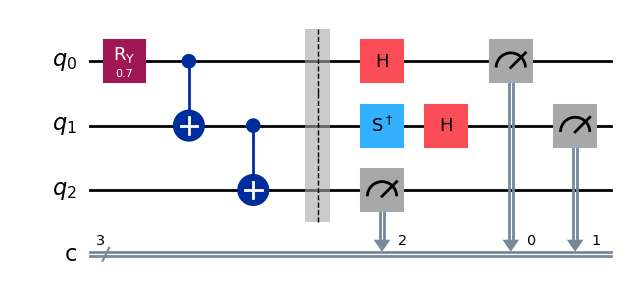

In [19]:
c = QuantumCircuit(3, 3)
c.ry(0.7, 0)
c.cx(0, 1)
c.cx(1, 2)
c.barrier()
# X-basis on q0
c.h(0)
# Y-basis on q1
c.sdg(1)
c.h(1)
# Z-basis on q2 (no change)
c.measure([0,1,2], [0,1,2])
c.draw("mpl")

## 7) Mini-exercise: Build and evaluate an Ising chain

Task: Build 
$$H = \sum_{i=0}^{m-2} Z_i Z_{i+1} + 0.5 \sum_{i=0}^{m-1} X_i$$
for `m=5` with `SparsePauliOp`, prepare `|+++++⟩`, and compute ⟨H⟩ using `Estimator`.

<details>
<summary><b>Show solution</b></summary>

```python
m = 5
terms = [("ZZ", [i, i+1], 1.0) for i in range(m-1)] + [("X", [i], 0.5) for i in range(m)]
H_ising = SparsePauliOp.from_sparse_list(terms, num_qubits=m)

qc_m = QuantumCircuit(m)
qc_m.h(range(m))
val = Estimator().run([qc_m], [H_ising]).result().values[0]
float(np.real(val))
```

</details>

## 8) Cheat‑sheet

- **SparsePauliOp**: efficient for big observables; supports algebra and conversion to dense via `.to_operator()`.
- **Pauli**: single string, quick inspections and sanity checks.
- **Operator**: dense matrices for few‑qubit exact maps; use sparingly as size grows fast.
- **Estimators** handle basis changes under the hood when evaluating expectation values.

## Additional information

**Created by:** Ricard Santiago Raigada García

**Version:** 1.0.0